# Word Vector- Example
This notebook sets up a word vectorization workflow on a toy example. Sentences are made up of spelled-out even and odd numbers.

## Setup
Import necesarry libraries and configure run settings:

In [1]:
import os, math, csv, re, itertools
import numpy as np
import pandas as pd
from collections import Counter
import jellyfish as jyfs
import datetime, time
import pickle
import matplotlib.pyplot as plt
import inflect
from random import *

## Obtain Corpus

We will import the CAB item description dataset in this section. The names must be contained within a list type object of format:

['Sentence 1', 'Sentence 2', 'Sentence 3']

In [2]:
ItemDescription = {}
ItemPartNumber = {}
i = 0

with open('../Data/Private/CAB_ItemVersion.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ItemDescription[i] = row['ItemDescription']
        ItemPartNumber[i] = row['ItemNumber']
        i += 1

In [3]:
# Extract list of part descriptions and numbers
ItemDescriptionList = [(v) for k,v in ItemDescription.items()]
ItemPartNumberList = [(v) for k,v in ItemPartNumber.items()]

## Text Processing
Some light text processing will be performed to remove numbers, punctuation, special characters, whitespace and single-character words.

In [4]:
ItemDescriptionList[0:10]

['AIR CLEANER BAND',
 '2-1/2ODX.250W AL TUBE',
 'AL TUBE 4 OD X .064 W T4',
 '5-1/2ODX.062W AL TUBE',
 '6 OD X.058W AL TUBE',
 '6 OD X.125W AL TUBE',
 '7 OD X.125W AL TUBE',
 'WHEEL SAFETY/SVCE MANUAL',
 'WHL SERV MANUAL-SPANISH',
 'ALUMINUM COIL STOCK (ALL)']

### Basics
Remove all non-letters, whitespace and single characters, lower space.

In [5]:
sentences = [re.sub('[^A-Za-z]', ' ', e) for e in ItemDescriptionList] # Remove all non-letter characters
sentences = [re.sub('\s+', ' ', e).strip().lower() for e in sentences] # Strip excess whitespace and lower case
sentences = [' '.join( [w for w in sent.split() if len(w)>1] ) for sent in sentences] # Remove single character "words
sentences[0:10]

['air cleaner band',
 'odx al tube',
 'al tube od',
 'odx al tube',
 'od al tube',
 'od al tube',
 'od al tube',
 'wheel safety svce manual',
 'whl serv manual spanish',
 'aluminum coil stock all']

### Resolve Typos/Abbreviations
The next text processing step is to attempt to remediate misspellings and abbreviations with string matching patterns. First step is to generate a list of unique words.

First, we need a term frequency list.

In [6]:
wordList = " ".join(sentences).split()
counts = Counter(wordList)

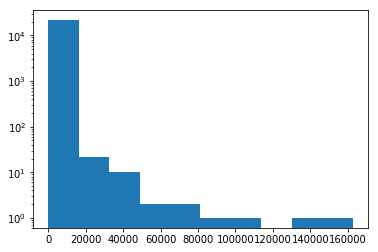

In [7]:
# Make a data frame of words, their counts, and original/new index values (not yet modified)

## Convert counter to data frame
wordcount = pd.DataFrame.from_dict(counts, orient='index').reset_index()
wordcount = wordcount.rename(columns={'index':'word', 0:'count'})
## Sort in descending order of count and reset index
wordcount = wordcount.sort_values('count', ascending=False).reset_index(drop = True)
## Copy index into original and new index columns
wordcount['og_index'] = wordcount['new_index'] = wordcount.index.values
wordcount['new_word'] = wordcount['word']

# Check it out
plt.hist(wordcount['count'])
plt.yscale('log', nonposy='clip')
plt.show()

Now we iterate down the list and examine Jaro Winkler distances as we go. If a distance is above our threshold, we update the "new index" value to the match.

In [8]:
# Prep word matrices
originalWords = wordcount.copy()
condensedWords = pd.DataFrame()
scores = []

# Set distance threshold
def distanceSet(currentCount, maxCount, baseline = 0.9):
    # This function sets a logarithmically increasing Jaro-Winkler distance threshold
    # based on the number of occurences of a word in the corpus.
    threshold = baseline + ((math.log(currentCount) / math.log(maxCount)) / (1/(1 - baseline)))
    return threshold


# Initialize loop parameters
cont_iteration = (len(originalWords) >= 1)

while cont_iteration == True:
    # Pop top word from originalWords
    originalWords, targetRecord = originalWords.drop(originalWords.head(1).index),originalWords.head(1)
    
    # Score against condensed newWords
    ## Pull out the targetWord
    targetWord = targetRecord.iloc[0]['word']
    targetIndex = targetRecord.iloc[0]['og_index']
    targetCount = targetRecord.iloc[0]['count']
    distanceThreshold = distanceSet(currentCount = targetCount, maxCount = 163000, baseline = 0.9)
    
    ## Score against condensed word list (if it exists)    
    if len(condensedWords) > 0:
        scores = [jyfs.jaro_winkler(targetWord, comp) for comp in condensedWords['new_word']]
        
        ## If a score has passed the threshold, update record with the new word
        if max(scores) >= distanceThreshold:
            ## Get the index of the match
            matchPointer = scores.index(max(scores))
            
            ## Create a new targetRecord with the match
            matchWord = condensedWords.iloc[matchPointer]['new_word']
            matchIndex = condensedWords.iloc[matchPointer]['new_index']
            # print("Match found: Target-", targetWord, " Match-", matchWord)
            targetRecord = pd.DataFrame({'word': targetWord,
                                                'new_word': matchWord,
                                                'og_index': int(targetIndex),
                                                'new_index': int(matchIndex)},
                                        index = [0])
    
    # Append to condensed words
    condensedWords = condensedWords.append(targetRecord)
    
    # Reset iteration checker
    cont_iteration = (len(originalWords) >= 1)
    
    # Status update
    if len(condensedWords) % 1000 == 0:
        print("Completed: ", len(condensedWords))
        print("Distance Threshold: ", distanceThreshold)
        print("================================================")

Completed:  100
Distance Threshold:  0.9740141148948647
Completed:  200
Distance Threshold:  0.9684340036458587
Completed:  300
Distance Threshold:  0.9644319793332964
Completed:  400
Distance Threshold:  0.960952506350742
Completed:  500
Distance Threshold:  0.9583363948286313
Completed:  600
Distance Threshold:  0.9562032518407266
Completed:  700
Distance Threshold:  0.9540825777685408
Completed:  800
Distance Threshold:  0.9526364354654147
Completed:  900
Distance Threshold:  0.9506787995940942
Completed:  1000
Distance Threshold:  0.9489982943915144
Completed:  1100
Distance Threshold:  0.947608467247143
Completed:  1200
Distance Threshold:  0.9464604137583945
Completed:  1300
Distance Threshold:  0.9451285083469352
Completed:  1400
Distance Threshold:  0.9438069655584598
Completed:  1500
Distance Threshold:  0.9428418215128216
Completed:  1600
Distance Threshold:  0.9418604193391131
Completed:  1700
Distance Threshold:  0.940747797319739
Completed:  1800
Distance Threshold:  0.939

Completed:  7900
Distance Threshold:  0.9134103001922923
Completed:  8000
Distance Threshold:  0.9134103001922923
Completed:  8100
Distance Threshold:  0.9134103001922923
Completed:  8200
Distance Threshold:  0.9134103001922923
Completed:  8300
Distance Threshold:  0.9134103001922923
Completed:  8400
Distance Threshold:  0.9115510038590948
Completed:  8500
Distance Threshold:  0.9115510038590948
Completed:  8600
Distance Threshold:  0.9115510038590948
Completed:  8700
Distance Threshold:  0.9115510038590948
Completed:  8800
Distance Threshold:  0.9115510038590948
Completed:  8900
Distance Threshold:  0.9115510038590948
Completed:  9000
Distance Threshold:  0.9115510038590948
Completed:  9100
Distance Threshold:  0.9115510038590948
Completed:  9200
Distance Threshold:  0.9115510038590948
Completed:  9300
Distance Threshold:  0.9115510038590948
Completed:  9400
Distance Threshold:  0.9115510038590948
Completed:  9500
Distance Threshold:  0.9091539539811754
Completed:  9600
Distance Thres

Completed:  15900
Distance Threshold:  0.9
Completed:  16000
Distance Threshold:  0.9
Completed:  16100
Distance Threshold:  0.9
Completed:  16200
Distance Threshold:  0.9
Completed:  16300
Distance Threshold:  0.9
Completed:  16400
Distance Threshold:  0.9
Completed:  16500
Distance Threshold:  0.9
Completed:  16600
Distance Threshold:  0.9
Completed:  16700
Distance Threshold:  0.9
Completed:  16800
Distance Threshold:  0.9
Completed:  16900
Distance Threshold:  0.9
Completed:  17000
Distance Threshold:  0.9
Completed:  17100
Distance Threshold:  0.9
Completed:  17200
Distance Threshold:  0.9
Completed:  17300
Distance Threshold:  0.9
Completed:  17400
Distance Threshold:  0.9
Completed:  17500
Distance Threshold:  0.9
Completed:  17600
Distance Threshold:  0.9
Completed:  17700
Distance Threshold:  0.9
Completed:  17800
Distance Threshold:  0.9
Completed:  17900
Distance Threshold:  0.9
Completed:  18000
Distance Threshold:  0.9
Completed:  18100
Distance Threshold:  0.9
Completed: 

Now save the results to a CSV and a pickle.

In [ ]:
condensedWords.to_csv("./tempfiles/condensedWords.csv")
condensedWords_filename = ("./tempfiles/condensedWords_final.p")
condensedWords.to_pickle(condensedWords_filename)

In [135]:
condensedWords = pd.read_pickle(condensedWords_filename)

Next, we need to re-map the part descriptions to use the new words.

In [136]:
# Build the replacement map using original words as indeces
wordReplacement_map = {}

for record in range(0, (len(condensedWords))):
    old_word = condensedWords.iloc[record]['word']
    new_word = condensedWords.iloc[record]['new_word']
    wordReplacement_map[old_word] = new_word

In [137]:
# Apply mappings to sentences using the above map.
## Initiate an empty list to catch the new sentences
new_sentences = []

## Loop through sentences and replace words
for sent in sentences:
    # Tokenize the sentence
    tokenized_sent = sent.split()
    
    # Prep an empty sentence to reconstruct the tokenized sentence with new words
    temp_sent = []
    
    # Rebuild the sentence using the word-new word map
    [temp_sent.append(wordReplacement_map[word]) for word in tokenized_sent]
    # Join the sentence
    temp_sent = " ".join(temp_sent)
    # Append the new sentence to the new_sentence list
    new_sentences.append(temp_sent)

### Append Base PNs

In [138]:
# String split base part number. PNs are of format C11-1010-23124, we want the first part (C11)
BasePNList = [x.split("-")[0] for x in ItemPartNumberList]

# Convert numerics to text
BasePNList = [w.replace('0', 'zero') for w in BasePNList]
BasePNList = [w.replace('1', 'one') for w in BasePNList]
BasePNList = [w.replace('2', 'two') for w in BasePNList]
BasePNList = [w.replace('3', 'three') for w in BasePNList]
BasePNList = [w.replace('4', 'four') for w in BasePNList]
BasePNList = [w.replace('5', 'five') for w in BasePNList]
BasePNList = [w.replace('6', 'six') for w in BasePNList]
BasePNList = [w.replace('7', 'seven') for w in BasePNList]
BasePNList = [w.replace('8', 'eight') for w in BasePNList]
BasePNList = [w.replace('9', 'nine') for w in BasePNList]
BasePNList[0:10]

['AAHzerozero',
 'AAR',
 'ABA',
 'ABH',
 'ABL',
 'ABP',
 'ABT',
 'ACCSSoneoneninesix',
 'ACCSSoneoneninesixS',
 'ACS']

In [139]:
BasePNList = [re.sub('[^A-Za-z]', ' ', e) for e in BasePNList] # Remove all non-letter characters
BasePNList = [re.sub('\s+', ' ', e).strip().lower() for e in BasePNList] # Strip excess whitespace and lower case
BasePNList[0:10]

['aahzerozero',
 'aar',
 'aba',
 'abh',
 'abl',
 'abp',
 'abt',
 'accssoneoneninesix',
 'accssoneoneninesixs',
 'acs']

In [140]:
# Append the base p/n to part description
sep = [" "] * len(BasePNList)
new_sentences = [x + y + z for x, y, z in zip(BasePNList, sep, new_sentences)]
new_sentences[0:10]

['aahzerozero air cleaner band',
 'aar odx al tube',
 'aba al tube od',
 'abh odx al tube',
 'abl od al tube',
 'abp od al tube',
 'abt od al tube',
 'accssoneoneninesix wheel safety svce manual',
 'accssoneoneninesixs whl serv manual spanish',
 'acs aluminum coil stock all']

### Drop Infrequent Terms
Filter out words below an occurence threshold. We will apply this filter to our sentences by replacing "new_word" in our wordReplacement_map dict with a blank.

In [141]:
# Extract the new words into a list, then count the occurences
newWordList = " ".join(new_sentences).split()
newCounts = Counter(newWordList)

## Convert counter to data frame and sort occurence
newwordcount = pd.DataFrame.from_dict(newCounts, orient='index').reset_index()
newwordcount = newwordcount.rename(columns={'index':'word', 0:'count'})
## Sort in descending order of count and reset index
newwordcount = newwordcount.sort_values('count', ascending=False).reset_index(drop = True)
## Check it out
newwordcount.head()

# Build a word to frequency map
wordFreq_map = {}
## Generate new list using word as key and count as value
for record in range(0, (len(newwordcount))):
    word = newwordcount.iloc[record]['word']
    count = newwordcount.iloc[record]['count']
    wordFreq_map[word] = count

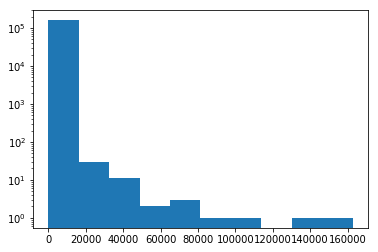

In [142]:
# Plot occurences 
plt.hist(newwordcount['count'])
plt.yscale('log', nonposy='clip')
plt.show()

Now that we have a map of word-to-frequency, let's run back through the sentences and drop words below some occurence threshold.

In [143]:
# Apply mappings to sentences using the above map.
## Initiate an empty list to catch the new sentences
final_sentences = []
## Set a threshold for occurence
occurence_threshold = 30

## Loop through sentences and replace words
for sent in new_sentences:
    # Tokenize the sentence
    tokenized_sent = sent.split()
    
    # Prep an empty sentence to reconstruct the tokenized sentence with only frequent terms
    temp_sent = []
    
    # Loop through each word in the sentence
    for word in tokenized_sent:
        # Get the word frequency
        word_freq = wordFreq_map[word]
        # Add word back into sentence only if it passes the threshold for freq.
        if word_freq >= occurence_threshold:
            temp_sent.append(word)
        # else:
            # print("Dropping word:", word, "with frequency ", word_freq)
    
    # Make sure that we didn't remove all words from a sentence. If we did, we will use the original sentence
    if len(temp_sent) == 0:
        # print("Drop sentence")
        continue
        # temp_sent = tokenized_sent
        # print("Word drop override")

    # Collapse tokenized sentence
    temp_sent = " ".join(temp_sent)
    # Join to final sentences list
    final_sentences.append(temp_sent)

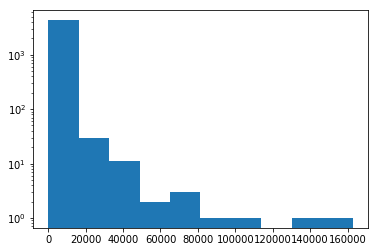

In [144]:
# Extract the new words into a list, then count the occurences
finalWordList = " ".join(final_sentences).split()
finalCounts = Counter(finalWordList)

## Convert counter to data frame and sort occurence
newwordcount = pd.DataFrame.from_dict(finalCounts, orient='index').reset_index()
newwordcount = newwordcount.rename(columns={'index':'word', 0:'count'})
## Sort in descending order of count and reset index
newwordcount = newwordcount.sort_values('count', ascending=False).reset_index(drop = True)
## Check it out
newwordcount.head()

# Build a word to frequency map
wordFreq_map = {}
## Generate new list using word as key and count as value
for record in range(0, (len(newwordcount))):
    word = newwordcount.iloc[record]['word']
    count = newwordcount.iloc[record]['count']
    wordFreq_map[word] = count
    
plt.hist(newwordcount['count'])
plt.yscale('log', nonposy='clip')
plt.show()

In [145]:
len(newwordcount)

4347

In [146]:
newwordcount[4340:]

,word,count
4340,ends,30
4341,qmconesixfivefive,30
4342,leightone,30
4343,ob,30
4344,cabwatch,30
4345,gd,30
4346,perlux,30


      word  count
0     seat  20169
1      cab  20146
2     brkt  20114
3  bracket  20103
4    eaton  20102


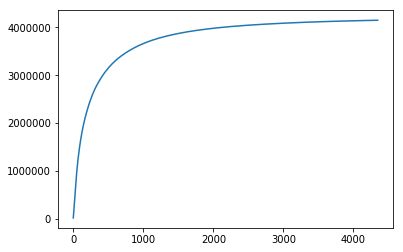

In [155]:
# Inspect most common words
print(newwordcount[0:5])

# Show cumulative count plot
newwordcount['cumcount'] = np.cumsum(newwordcount['count'])
plt.plot(newwordcount['cumcount'])

### Subsample Frequent Words

In [148]:
# Extract the new words into a list, then count the occurences
newWordList = " ".join(final_sentences).split()
newCounts = Counter(newWordList)

## Convert counter to data frame and sort occurence
newwordcount = pd.DataFrame.from_dict(newCounts, orient='index').reset_index()
newwordcount = newwordcount.rename(columns={'index':'word', 0:'count'})
## Sort in descending order of count and reset index
newwordcount = newwordcount.sort_values('count', ascending=False).reset_index(drop = True)
## Check it out
newwordcount.head()

# Build a word to frequency map
wordFreq_map = {}
## Generate new list using word as key and count as value
for record in range(0, (len(newwordcount))):
    word = newwordcount.iloc[record]['word']
    count = newwordcount.iloc[record]['count']
    wordFreq_map[word] = count

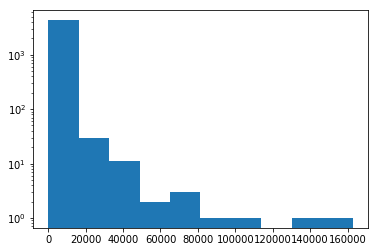

In [149]:
# Plot occurences 
plt.hist(newwordcount['count'])
plt.yscale('log', nonposy='clip')
plt.show()

In [151]:
# Apply mappings to sentences using the above map.
## Initiate an empty list to catch the new sentences
subsampled_sentences = []
## Set a threshold for occurence
occurence_threshold = 20000

In [152]:
## Loop through sentences and replace words
for sent in final_sentences:
    # print("===================")
    # print(sent)
    
    # Tokenize the sentence
    tokenized_sent = sent.split()
    
    # Prep an empty sentence to reconstruct the tokenized sentence with only frequent terms
    temp_sent = []
    
    # Loop through each word in the sentence
    for word in tokenized_sent:
        # Get the word frequency
        word_freq = wordFreq_map[word]
        # Get probability of inclusion
        p_inclusion = occurence_threshold / word_freq
        rnd_draw = random()
        
        if rnd_draw < p_inclusion:
            temp_sent.append(word)
        # else:
            # print("Dropping word ", word)
    # print(temp_sent)
    
    # Make sure that we didn't remove all words from a sentence. If we did, drop the sentence altogether
    if len(temp_sent) == 0:
        # print("Drop sentence")
        continue

    # Collapse tokenized sentence
    temp_sent = " ".join(temp_sent)
    # Join to final sentences list
    subsampled_sentences.append(temp_sent)

Now examing the distribution of word frequencies after sub-sampling

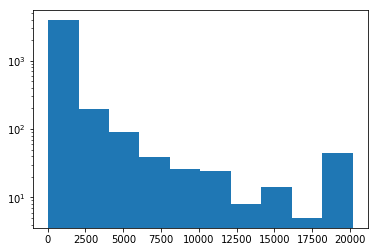

In [153]:
# Extract the new words into a list, then count the occurences
finalWordList = " ".join(subsampled_sentences).split()
finalCounts = Counter(finalWordList)

## Convert counter to data frame and sort occurence
newwordcount = pd.DataFrame.from_dict(finalCounts, orient='index').reset_index()
newwordcount = newwordcount.rename(columns={'index':'word', 0:'count'})
## Sort in descending order of count and reset index
newwordcount = newwordcount.sort_values('count', ascending=False).reset_index(drop = True)
## Check it out
newwordcount.head()
    
plt.hist(newwordcount['count'])
plt.yscale('log', nonposy='clip')
plt.show()

In [159]:
subsampled_sentences[100:110]

['aoneone valve',
 'aoneone bracket mud flap',
 'aoneone mud flap rh',
 'aoneone hood pivot top',
 'aoneone bracket hood pivot top',
 'aoneone frt eng sprt',
 'aoneone frt eng sprt',
 'aoneone frnt eng supt',
 'aoneone bracket frnt eng supt',
 'aoneone bracket frnt eng supt']

## Serialize the Results
The processed text is now serialized to be picked up by the training notebook.

In [171]:
type(subsampled_sentences)

list

In [175]:
with open('./tempfiles/cleanParts.pkl', 'wb') as f:
   pickle.dump(subsampled_sentences, f)